# 1. Librerias

In [1]:
#1. Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# 2. Carga de datos

In [2]:
#2. Carga de datos

df = pd.read_csv(r'C:\Users\sebas\Downloads\AI Para Sensor\Contratos2014_2023.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

C:\Users\sebas\AppData\Local\Temp\ipykernel_16064\1386963258.py:3: DtypeWarning: Columns (6,16,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\sebas\Downloads\AI Para Sensor\Contratos2014_2023.csv')


# 3. Procesamiento de fechas

In [3]:
# 3. Filtrado de datos

coah_df = df.loc[df['Siglas de la Institución'] == 'COAH']
coah_df = coah_df.reset_index(drop=True)

In [11]:
coah_df['Fecha de apertura'] = coah_df['Fecha de apertura'].str.split(' ', expand = True)[0]

In [16]:
# 4. Formato de tiempo

f_inicio = pd.to_datetime(coah_df['Fecha de inicio del contrato'])
f_fin = pd.to_datetime(coah_df['Fecha de fin del contrato'])

coah_df.loc[f_inicio.index, 'Fecha de inicio del contrato'] = f_inicio.values
coah_df.loc[f_fin.index, 'Fecha de fin del contrato'] = f_fin.values
coah_df['Duración del contrato'] = (coah_df['Fecha de fin del contrato'] - coah_df['Fecha de inicio del contrato']).dt.days

# 4.1. Formatos de fecha de apertura y fallo

coah_df['Fecha de apertura'] = coah_df['Fecha de apertura'].str.split(' ', expand = True)[0]
coah_df['Fecha de fallo'] = coah_df['Fecha de fallo'].str.split(' ', expand = True)[0]

coah_df['Duración de apertura'] = pd.to_datetime(coah_df['Fecha de fallo']) - pd.to_datetime(coah_df['Fecha de apertura'])
coah_df['Duración de apertura'] = coah_df['Duración de apertura'].dt.days

C:\Users\sebas\AppData\Local\Temp\ipykernel_16064\1313292995.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  coah_df.loc[f_inicio.index, 'Fecha de inicio del contrato'] = f_inicio.values
C:\Users\sebas\AppData\Local\Temp\ipykernel_16064\1313292995.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  coah_df.loc[f_fin.index, 'Fecha de fin del contrato'] = f_fin.values


# 4. Procesamiento de tipo de procedimiento

In [18]:
coah_df.loc[coah_df['Tipo de procedimiento'] == 'Licitación Pública', 'Tipo de procedimiento'] = 'LICITACIÓN PÚBLICA'
coah_df.loc[coah_df['Tipo de procedimiento'] == 'Invitación a Cuando Menos 3 Personas', 'Tipo de procedimiento'] = 'INVITACIÓN A CUANDO MENOS 3 PERSONAS'
coah_df.loc[coah_df['Tipo de procedimiento'] == 'Invitación a cuando menos 3 personas', 'Tipo de procedimiento'] = 'INVITACIÓN A CUANDO MENOS 3 PERSONAS'
coah_df.loc[coah_df['Tipo de procedimiento'] == 'Adjudicación directa', 'Tipo de procedimiento'] = 'ADJUDICACIÓN DIRECTA'
coah_df.loc[coah_df['Tipo de procedimiento'] == 'Adjudicación Directa Federal', 'Tipo de procedimiento'] = 'ADJUDICACIÓN DIRECTA'
coah_df.loc[coah_df['Tipo de procedimiento'] == 'Otro', 'Tipo de procedimiento'] = 'OTRAS CONTRATACIONES'

# Exportamos la base limpia para un pre análisis en Power BI

coah_df.to_excel('Coahuila_Contratos.xlsx', index = False)

# 5. Fecha de creación de la empresa

In [19]:
# Añadir fecha de creación de la empresa

empresas = pd.read_excel(r'Empresas.xlsx')
empresas = empresas[['Proveedor o contratista', 'Fecha de apertura']]
empresas_name = empresas['Proveedor o contratista'].values
empresas_fechas = empresas['Fecha de apertura'].values
coah_df['Apertura_empresa'] = coah_df.shape[0] * [np.nan]


for name,fecha in zip(empresas_name,empresas_fechas):
    coah_df.loc[coah_df['Proveedor o contratista'] == name, 'Apertura_empresa'] = str(fecha)

In [20]:
coah_df.loc[coah_df['Apertura_empresa'] == 'NE', 'Apertura_empresa'] = np.nan

# 6. Tratamiento de valores atípicos

In [57]:
#Eliminación de valores atípicos

data = coah_df.copy()
#data = data.loc[data['Tipo de contratación'].isin(['Adquisiciones','Obra Pública'])]
data = data.loc[data['Tipo de procedimiento'] == 'LICITACIÓN PÚBLICA']
data = data.loc[~data['Fecha de firma del contrato'].str.contains('2023', na = False)]
data = data.loc[data.Apertura_empresa.notna()]
data = data.loc[data['Duración de apertura'].notna()]
data['Apertura_empresa'] = pd.to_datetime(data['Apertura_empresa'])
data['Dias_apertura_firma'] = (pd.to_datetime(data['Fecha de inicio del contrato']) - data['Apertura_empresa']).dt.days 

data['PesosAlDia'] = data['Importe del contrato']/(data['Duración del contrato'] + 0.000000000000000000000001)
data.shape

data = data.loc[data.Dias_apertura_firma >= 0]

data = data.loc[data['Duración de apertura'] >= 0]



In [58]:
data['Año contrato'] = data['Fecha de inicio del contrato'].dt.year

In [59]:
data = data.loc[~data['Título del expediente'].str.contains('DESPENSA')]
data = data.loc[~data['Título del expediente'].str.contains('FORTI')]
data = data.loc[~data['Título del expediente'].str.contains('VALES')]
data = data.reset_index()

In [60]:
escalado = ['Importe del contrato ESCALADO', 'PesosAlDia ESCALADO','Duración del contrato ESCALADO', 'Dias_apertura_firma_escalado',
            'Duracion_apertura_escalado']
escalar = ['Importe del contrato', 'PesosAlDia','Duración del contrato', 'Dias_apertura_firma', 'Duración de apertura']


for scale, esc in zip(escalado, escalar):
    fitted_data, fitted_lambda = stats.boxcox(data[esc] + 0.00000000000000000000000000001)
    data[scale] = fitted_data
    

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [61]:
qr_data = data[['PesosAlDia ESCALADO', 'Dias_apertura_firma_escalado', 'Duracion_apertura_escalado']]
# Identificar y eliminar outliers usando el método IQR
Q1 = qr_data.quantile(0.25)
Q3 = qr_data.quantile(0.75)
IQR = Q3 - Q1

data_no_outliers = qr_data[~((qr_data < (Q1 - 1.5 * IQR)) | (qr_data > (Q3 + 1.5 * IQR))).any(axis=1)]

data = data.loc[data_no_outliers.index.values]

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

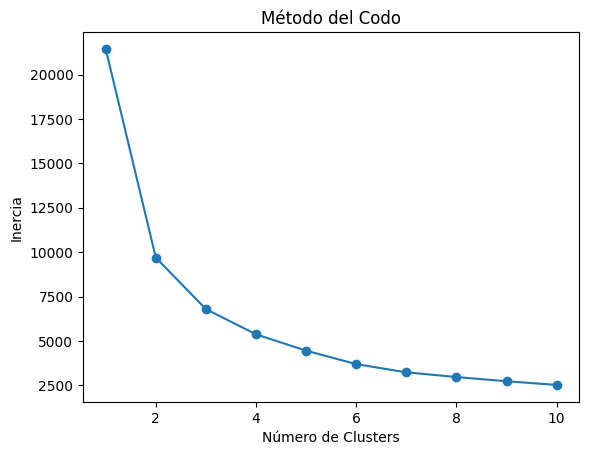

In [62]:
inertia = []

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data[['PesosAlDia ESCALADO', 'Dias_apertura_firma_escalado', 'Duracion_apertura_escalado']])
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


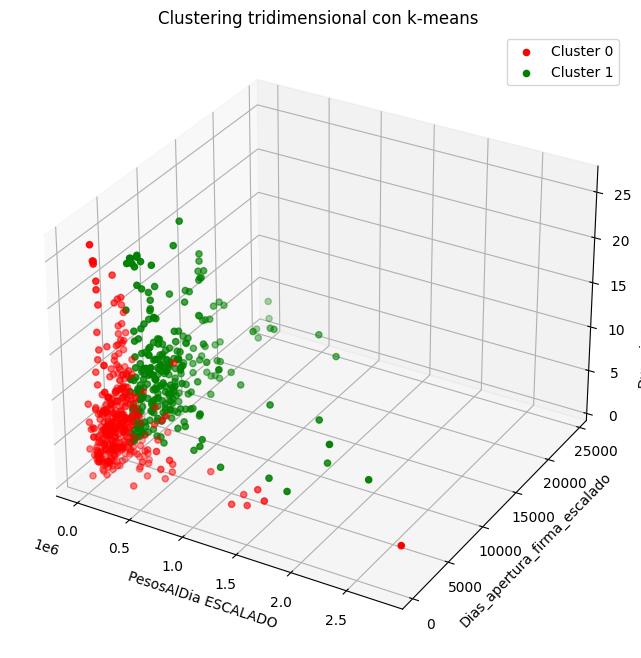

In [64]:
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters=2, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['PesosAlDia ESCALADO', 'Dias_apertura_firma_escalado', 'Duracion_apertura_escalado']])


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue']
for cluster, color in zip(range(2), colors):
    cluster_data = data[data['Cluster'] == cluster]
    ax.scatter(cluster_data['PesosAlDia'], cluster_data['Dias_apertura_firma'], cluster_data['Duración de apertura'], c=color, label=f'Cluster {cluster}')

ax.set_xlabel('PesosAlDia ESCALADO')
ax.set_ylabel('Dias_apertura_firma_escalado')
ax.set_zlabel('Duracion_apertura_escalado')
ax.set_title('Clustering tridimensional con k-means')
ax.legend()
plt.show()

In [67]:
data.columns

Index(['index', 'Siglas de la Institución', 'Orden de gobierno', 'Institución',
       'Clave de la UC', 'Nombre de la UC', 'Código del expediente',
       'Título del expediente', 'Número del procedimiento', 'Fecha de fallo',
       'Fecha de publicación', 'Fecha de apertura',
       'Carácter del procedimiento', 'Tipo de contratación',
       'Tipo de procedimiento', 'Forma de participación',
       'Código del contrato', 'Título del contrato',
       'Fecha de inicio del contrato', 'Fecha de fin del contrato',
       'Importe del contrato', 'Moneda del contrato', 'Estatus del contrato',
       'Fecha de firma del contrato', 'Compra consolidada',
       'Proveedor o contratista', 'Estratificación de la empresa',
       'Dirección del anuncio', 'Clave CUCOP', 'Duración del contrato',
       'Duración de apertura', 'Apertura_empresa', 'Dias_apertura_firma',
       'PesosAlDia', 'Año contrato', 'Importe del contrato ESCALADO',
       'PesosAlDia ESCALADO', 'Duración del contrato ESCALAD

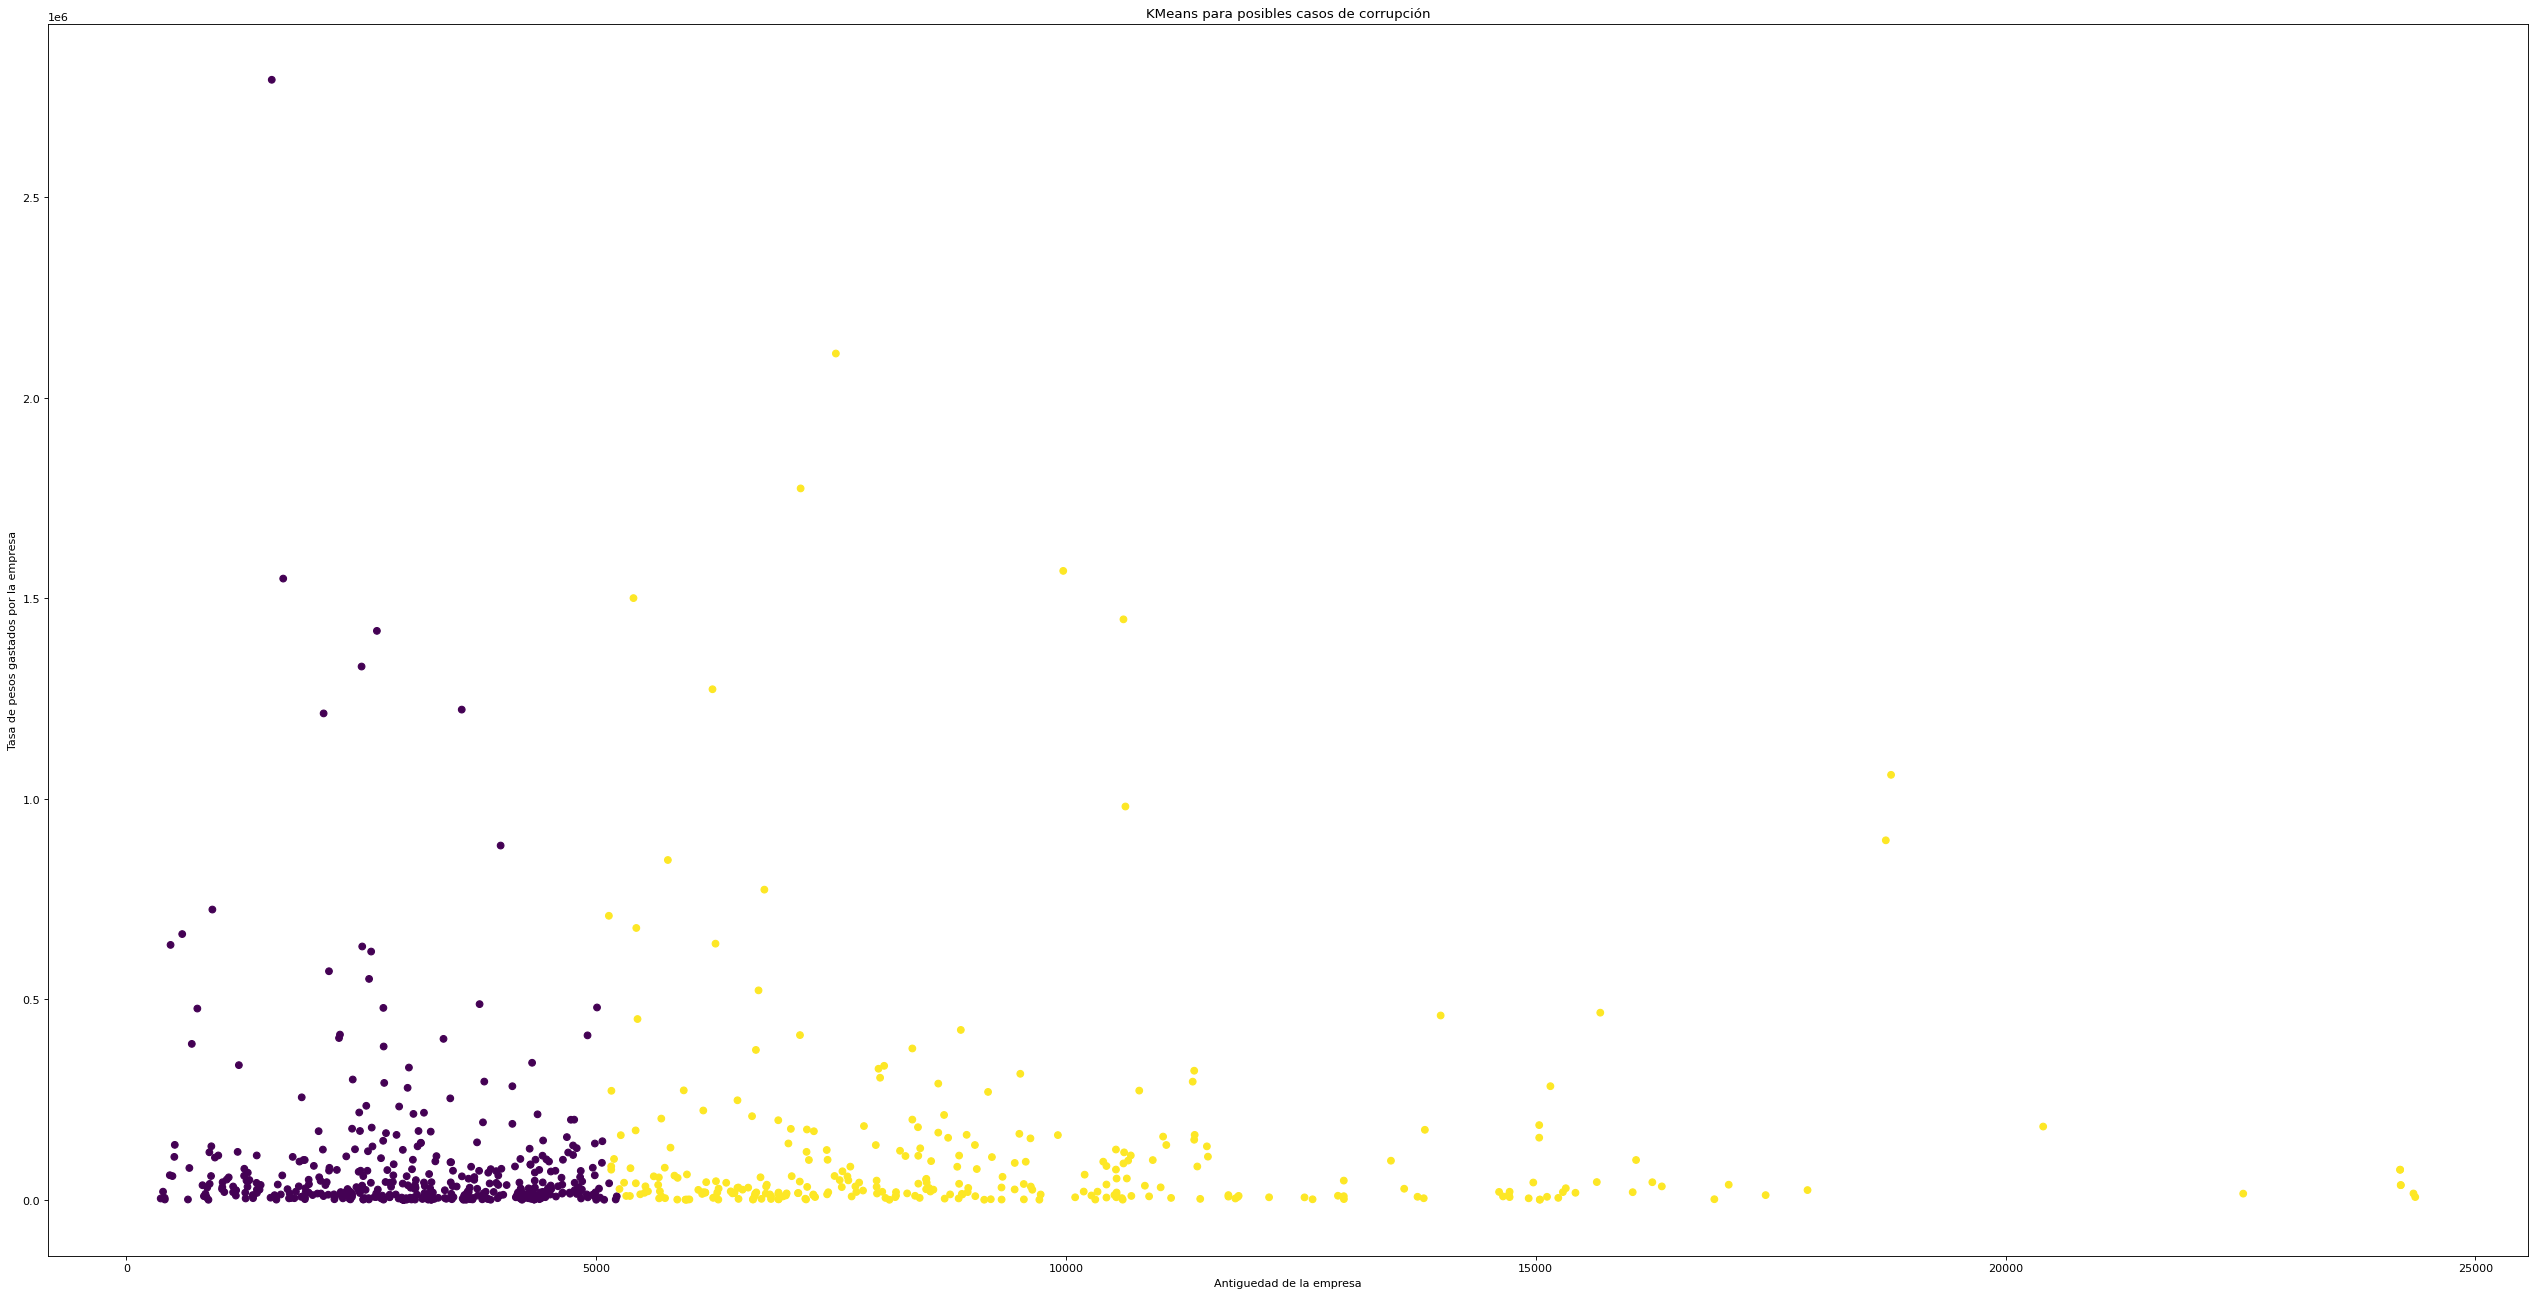

In [72]:
from matplotlib.pyplot import figure

figure(figsize=(40, 20), dpi=80)
plt.scatter(data['Dias_apertura_firma'], data['PesosAlDia'], c = data['Cluster'])
plt.xlabel('Antiguedad de la empresa')
plt.ylabel('Tasa de pesos gastados por la empresa')
plt.title('KMeans para posibles casos de corrupción')
plt.show()

In [85]:
anomaly[coah_df.columns].to_excel('Posibles_casos.xlsx', encoding = 'utf-8-sig', index = False)

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)
